## Working environment setup

In [ ]:
# If working in a local environement

using_kaggle = False
work_dir = ''
output_dir = ''

In [1]:
# If working on colab

using_kaggle = False

from google.colab import drive
drive.mount('/content/drive')

import os

# Change to your desired directory
work_dir = '/content/drive/My Drive/finegrained'
output_dir = ''
os.chdir(work_dir)

# Confirm the change
print("Current Working Directory:", os.getcwd())

Mounted at /content/drive
Current Working Directory: /content/drive/.shortcut-targets-by-id/1_73eHJYmosd__ofYgtkb6KpWSc9qkQic/finegrained


In [2]:
# # If working on kaggle (Not recommanded for just testing the code but was useful for us to train the models on kaggle GPU)

# using_kaggle = True

# import os
# import sys

# # Specify your dataset folder within /kaggle/input/
# input_dir = '/kaggle/input/fgvr-cars' # choose wether you want to run it on the cars dataset or the planes dataset (for planes dataset replace 'cars' with 'planes)
# output_dir = '/kaggle/working'


# # Change the working directory
# os.chdir(input_dir)

# # Confirm the change
# print("Current Working Directory:", os.getcwd())

# # Add the input directory to Python's module search path
# # This allows you to import your custom modules stored in /kaggle/input/
# sys.path.append(input_dir)

## Importations

In [2]:
from __future__ import print_function
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torch.autograd import Variable

import torchvision
import torchvision.models
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

from basic_conv import *
from example.model.smooth_cross_entropy import smooth_crossentropy
from example.utility.bypass_bn import enable_running_stats, disable_running_stats
from vic.loss import CharbonnierLoss
from sam import SAM

# Conditional imports for Kaggle
if using_kaggle:
    from drive_connect.drive_connect import (
        upload_or_update_file_to_drive,
        drive_service,
        upload_folder_structure,
        create_drive_folder,
        google_drive_parent_folder_id
    )

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Baseline Model definition

In [ ]:
class PlaneModelCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlaneModelCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  # Adjusted for input image size 448x448
        self.fc2 = nn.Linear(128, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)  # Maintain batch size

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

## PMAL Model definitoion and utils

In [ ]:
# code mostly extracted from the paper code with slight modifications

def cosine_anneal_schedule(t, nb_epoch, lr):
    cos_inner = np.pi * (t % (nb_epoch))
    cos_inner /= (nb_epoch)
    cos_out = np.cos(cos_inner) + 1
    return float(lr / 2 * cos_out)

def CELoss(x, y):
    from example.model.smooth_cross_entropy import smooth_crossentropy
    return smooth_crossentropy(x, y, smoothing=0.1)

def test(net, criterion, batch_size, test_path):
    net.eval()
    use_cuda = torch.cuda.is_available()
    test_loss = 0
    correct = 0
    correct_com = 0
    total = 0
    idx = 0
    device = torch.device("cuda")

    transform_test = transforms.Compose([
        transforms.Resize((550, 550)),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    testset = torchvision.datasets.ImageFolder(root=test_path,
                                               transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

    for batch_idx, (inputs, targets) in enumerate(testloader):
        idx = batch_idx
        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        output_1, output_2, output_3, output_ORI, map1, map2, map3 = net(inputs)

        outputs_com = output_1 + output_2 + output_3 + output_ORI

        loss = criterion(output_ORI, targets).mean()

        test_loss += loss.item()
        _, predicted = torch.max(output_ORI.data, 1)
        _, predicted_com = torch.max(outputs_com.data, 1)

        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        correct_com += predicted_com.eq(targets.data).cpu().sum()

        print('Step: %d | Loss: %.3f |Combined Acc: %.3f%% (%d/%d)' % (
        batch_idx, test_loss / (batch_idx + 1),
        100. * float(correct_com) / total, correct_com, total))

    test_acc_en = 100. * float(correct_com) / total
    test_loss = test_loss / (idx + 1)

    return test_acc_en, test_loss

In [5]:
# Code for the model's architechture extracted from the paper code

class Features(nn.Module):
    def __init__(self, net_layers):
        super(Features, self).__init__()
        self.net_layer_0 = nn.Sequential(net_layers[0])
        self.net_layer_1 = nn.Sequential(net_layers[1])
        self.net_layer_2 = nn.Sequential(net_layers[2])
        self.net_layer_3 = nn.Sequential(net_layers[3])
        self.net_layer_4 = nn.Sequential(*net_layers[4])
        self.net_layer_5 = nn.Sequential(*net_layers[5])
        self.net_layer_6 = nn.Sequential(*net_layers[6])
        self.net_layer_7 = nn.Sequential(*net_layers[7])


    def forward(self, x):
        x = self.net_layer_0(x)
        x = self.net_layer_1(x)
        x = self.net_layer_2(x)
        x = self.net_layer_3(x)
        x = self.net_layer_4(x)
        x1 = self.net_layer_5(x)
        x2 = self.net_layer_6(x1)
        x3 = self.net_layer_7(x2)
        return x1, x2, x3


class Anti_Noise_Decoder(nn.Module):
    def __init__(self, scale, in_channel):
        super(Anti_Noise_Decoder, self).__init__()
        self.Sigmoid = nn.Sigmoid()

        in_channel = in_channel // (scale * scale)

        self.skip = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(64, 3, 3, 1, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)

        )

        self.process = nn.Sequential(
            nn.PixelShuffle(scale),
            nn.Conv2d(in_channel, 256, 3, 1, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.PixelShuffle(2),
            nn.Conv2d(16, 3, 3, 1, 1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x, map):
        return self.skip(x) + self.process(map)

class Network_Wrapper(nn.Module):
    def __init__(self, net_layers, num_class, classifier):
        super().__init__()
        self.Features = Features(net_layers)
        self.classifier_pool = nn.Sequential(classifier[0])
        self.classifier_initial = nn.Sequential(classifier[1])
        self.sigmoid = nn.Sigmoid()
        self.lrelu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

        self.max_pool1 = nn.MaxPool2d(kernel_size=56, stride=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=28, stride=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=14, stride=1)

        self.conv_block1 = nn.Sequential(
            BasicConv(512, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier1 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, num_class)
        )

        self.conv_block2 = nn.Sequential(
            BasicConv(1024, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier2 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, num_class),
        )

        self.conv_block3 = nn.Sequential(
            BasicConv(2048, 512, kernel_size=1, stride=1, padding=0, relu=True),
            BasicConv(512, 1024, kernel_size=3, stride=1, padding=1, relu=True)
        )
        self.classifier3 = nn.Sequential(
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ELU(inplace=True),
            nn.Linear(512, num_class),
        )


    def forward(self, x):
        x1, x2, x3 = self.Features(x)
        map1 = x1.clone()
        map2 = x2.clone()
        map3 = x3.clone()

        classifiers = self.classifier_pool(x3).view(x3.size(0), -1)
        classifiers = self.classifier_initial(classifiers)

        x1_ = self.conv_block1(x1)
        x1_ = self.max_pool1(x1_)
        x1_f = x1_.view(x1_.size(0), -1)
        x1_c = self.classifier1(x1_f)

        x2_ = self.conv_block2(x2)
        x2_ = self.max_pool2(x2_)
        x2_f = x2_.view(x2_.size(0), -1)
        x2_c = self.classifier2(x2_f)


        x3_ = self.conv_block3(x3)
        x3_ = self.max_pool3(x3_)
        x3_f = x3_.view(x3_.size(0), -1)
        x3_c = self.classifier3(x3_f)

        return x1_c, x2_c, x3_c, classifiers, map1, map2, map3

class Student_Wrapper(nn.Module):
    def __init__(self, net_layers, classifier):
        super(Student_Wrapper, self).__init__()
        self.net_layer_0 = nn.Sequential(net_layers[0])
        self.net_layer_1 = nn.Sequential(net_layers[1])
        self.net_layer_2 = nn.Sequential(net_layers[2])
        self.net_layer_3 = nn.Sequential(net_layers[3])
        self.net_layer_4 = nn.Sequential(*net_layers[4])
        self.net_layer_5 = nn.Sequential(*net_layers[5])
        self.net_layer_6 = nn.Sequential(*net_layers[6])
        self.net_layer_7 = nn.Sequential(*net_layers[7])

        self.net_layer_8 = nn.Sequential(classifier[0])
        self.net_layer_9 = nn.Sequential(classifier[1])

        self.bn1 = nn.Sequential(nn.BatchNorm2d(64))
        self.relu = nn.Sequential(nn.ReLU())

    def forward(self, x):
        x = self.net_layer_0(x)
        x = self.net_layer_1(x)
        x = self.net_layer_2(x)
        x = self.net_layer_3(x)
        x = self.net_layer_4(x)
        x1 = self.net_layer_5(x)
        x2 = self.net_layer_6(x1)
        x3 = self.net_layer_7(x2)

        feat = self.net_layer_8(x3)
        feat = feat.view(feat.size(0), -1)
        out = self.net_layer_9(feat)

        return out, x1, x2, x3

## Data loading and transformation

In [6]:
# Augmentation of the train data during training (no a pre-training data augmentation)

def img_add_noise(x, augmentation_seq):
    x = x.permute(0, 2, 3, 1).cpu().numpy()  # Convert to (B, H, W, C)
    augmented = [augmentation_seq(image=img)["image"] for img in x]  # Apply augmentations
    x_aug = torch.tensor(augmented).permute(0, 3, 1, 2).float()  # Back to (B, C, H, W)
    return x_aug


# Define Albumentations augmentations
trans_seq_aug = A.Compose([
    A.OneOf([
        A.Affine(
            scale=(0.8, 1.2),
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-15, 15),
            shear=(-15, 15),
            mode=1
        )
    ], p=0.2),  # Replaces `iaa.Sometimes(0.2, ...)`
    A.GaussianBlur(blur_limit=(0, 3.0), p=0.5)  # Replaces `iaa.Sometimes(0.5, ...)`
])

trans_seq = A.Compose([
    A.GaussNoise(var_limit=(0.0, 0.05), mean=0, p=1.0)  # Replaces `iaa.AdditiveGaussianNoise`
])


/usr/local/lib/python3.11/dist-packages/pydantic/main.py:214: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [12]:
# Define parameters
import datetime

data_path = "downsampled_plane_data"

store_name=f'results/downsampled_plane_ResNet50_PMAL/{str(datetime.datetime.now())}'
exp_dir = output_dir+store_name

if not os.path.isdir(exp_dir):
    os.makedirs(exp_dir)

if using_kaggle:
    results_folder_id = create_drive_folder('results',google_drive_parent_folder_id)
    results_folder_id = create_drive_folder('downsampled_StanfordCars_ResNet50_PMAL',results_folder_id)
    results_folder_id = create_drive_folder(str(datetime.datetime.now()),results_folder_id)

nb_epoch=60
batch_size=10
num_class=8
start_epoch=0
data_path = data_path
alpha = 1

In [8]:
# Load train data

use_cuda = torch.cuda.is_available()
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.Resize((550, 550)),
    transforms.RandomCrop(448, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.ImageFolder(root=data_path+'/train', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

==> Preparing data..


In [9]:
transform_test = transforms.Compose([
    transforms.Resize((550, 550)),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
testset = torchvision.datasets.ImageFolder(root=data_path+'/test',
                                            transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Training the baseline model

In [ ]:
# Define hyperparameters
batch_size = 10
num_classes = 8
num_epochs = 60

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')



# Model, loss function, and optimizer
model = PlaneModelCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    # Testing phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(testloader)
    test_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")



## Training the PMAL model (the teacher model)

In [ ]:
net = torchvision.models.resnet50()
state_dict = load_state_dict_from_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')
net.load_state_dict(state_dict)
fc_features = net.fc.in_features
net.fc = nn.Linear(fc_features, num_class)

net_layers = list(net.children())
classifier = net_layers[8:10]
net_layers = net_layers[0:8]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


In [ ]:
# Training the teacher model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Network_Wrapper(net_layers, num_class, classifier)
net = net.float()  # Ensure all parameters are `float`
net = net.to(device)  # Move the model to the correct device
netp = torch.nn.DataParallel(net, device_ids=[0])

decoder1 = Anti_Noise_Decoder(1, 512).to(device)
decoder2 = Anti_Noise_Decoder(2, 1024).to(device)
decoder3 = Anti_Noise_Decoder(4, 2048).to(device)

CB_loss = CharbonnierLoss()

base_optimizer = torch.optim.SGD
optimizer = SAM([
    {'params': net.classifier_initial.parameters(), 'lr': 0.01},
    {'params': net.conv_block1.parameters(), 'lr': 0.01},
    {'params': net.classifier1.parameters(), 'lr': 0.01},
    {'params': net.conv_block2.parameters(), 'lr': 0.01},
    {'params': net.classifier2.parameters(), 'lr': 0.01},
    {'params': net.conv_block3.parameters(), 'lr': 0.01},
    {'params': net.classifier3.parameters(), 'lr': 0.01},
    {'params': decoder1.skip.parameters(), 'lr': 0.01},
    {'params': decoder1.process.parameters(), 'lr': 0.01},
    {'params': decoder2.skip.parameters(), 'lr': 0.01},
    {'params': decoder2.process.parameters(), 'lr': 0.01},
    {'params': decoder3.skip.parameters(), 'lr': 0.01},
    {'params': decoder3.process.parameters(), 'lr': 0.01},
    {'params': net.Features.parameters(), 'lr': 0.001}
], base_optimizer, adaptive=False, momentum=0.9, weight_decay=5e-4)

max_val_acc = 0
lr = [0.01] * 13 + [0.001]

for epoch in range(start_epoch, nb_epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    train_loss1 = 0
    train_loss2 = 0
    train_loss3 = 0
    train_loss4 = 0
    train_loss5 = 0
    correct = 0
    total = 0
    idx = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        idx = batch_idx
        if inputs.shape[0] < batch_size:
            continue
        inputs, targets = inputs.to(device), targets.to(device)

        for nlr in range(len(optimizer.param_groups)):
            optimizer.param_groups[nlr]['lr'] = cosine_anneal_schedule(epoch, nb_epoch, lr[nlr])

        # Augmentations
        inputs1_gt = img_add_noise(inputs, trans_seq_aug).to(device)
        inputs1 = img_add_noise(inputs1_gt, trans_seq).to(device)
        inputs1 = inputs

        # H1 first forward-backward step
        enable_running_stats(netp)
        optimizer.zero_grad()
        output_1, _, _, _, map1, _, _ = netp(inputs1)
        loss1_c = CELoss(output_1, targets).mean()
        inputs1_syn = decoder1(inputs1, map1)
        loss1_g = CB_loss(inputs1_syn, inputs1_gt)
        loss1 = loss1_c + (alpha * loss1_g)
        loss1.backward()
        optimizer.first_step(zero_grad=True)

        # H1 second forward-backward step
        disable_running_stats(netp)
        optimizer.zero_grad()
        output_1, _, _, _, map1, _, _ = netp(inputs1)
        loss1_c = CELoss(output_1, targets).mean()
        inputs1_syn = decoder1(inputs1, map1)
        loss1_g = CB_loss(inputs1_syn, inputs1_gt)
        loss1_ = loss1_c + (alpha * loss1_g)
        loss1_.backward()
        optimizer.second_step(zero_grad=True)

        _, predicted = torch.max(output_1.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        train_loss += loss1.item()
        train_loss1 += loss1.item()
        train_loss4 += loss1_g.item()

        if batch_idx % 1 == 0:
            print(
                'Step: %d | Loss1: %.3f | Loss_Gen: %.5f | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (
                    batch_idx, train_loss1 / (batch_idx + 1), train_loss4 / (batch_idx + 1),
                    train_loss / (batch_idx + 1),
                    100. * float(correct) / total, correct, total))

    train_acc = 100. * float(correct) / total
    train_loss = train_loss / (idx + 1)
    with open(exp_dir + '/results_train.txt', 'a') as file:
        file.write(
            'Iteration %d | train_acc = %.5f | train_loss = %.5f | Loss1: %.3f | Loss_Gen: %.5f |\n' % (
                epoch, train_acc, train_loss, train_loss1 / (idx + 1), train_loss4 / (idx + 1)))
    if using_kaggle:
        upload_or_update_file_to_drive(
            exp_dir + '/results_train.txt',
            'results_train.txt',
            results_folder_id
        )

    val_acc_com, val_loss = test(net, CELoss, 7, data_path+'/test')
    if val_acc_com > max_val_acc:
        max_val_acc = val_acc_com
        net.cpu()
        decoder1.cpu()
        decoder2.cpu()
        decoder3.cpu()
        torch.save(net, exp_dir + '/model.pth')
        torch.save(decoder1, exp_dir + '/decoder1.pth')
        torch.save(decoder2, exp_dir + '/decoder2.pth')
        torch.save(decoder3, exp_dir + '/decoder3.pth')
        if using_kaggle:
          # Upload or update the result files to Google Drive
          upload_or_update_file_to_drive(
              exp_dir + '/model.pth',
              'model.pth',
              results_folder_id
          )
          upload_or_update_file_to_drive(
              exp_dir + '/decoder1.pth',
              'decoder1.pth',
              results_folder_id
          )
          upload_or_update_file_to_drive(
              exp_dir + '/decoder2.pth',
              'decoder2.pth',
              results_folder_id
          )
          upload_or_update_file_to_drive(
              exp_dir + '/decoder3.pth',
              'decoder3.pth',
              results_folder_id
          )
        net.to(device)
        decoder1.to(device)
        decoder2.to(device)
        decoder3.to(device)
    with open(exp_dir + '/results_test.txt', 'a') as file:
        file.write('Iteration %d, test_acc_combined = %.5f, test_loss = %.6f\n' % (
            epoch, val_acc_com, val_loss))
    if using_kaggle:
        upload_or_update_file_to_drive(
             exp_dir + '/results_test.txt',
            'results_test.txt',
            results_folder_id
        )

## Visualisation of image transformation and model classification

In [ ]:
def predict(net, test_path, batch_size=4):
    """
    Predicts classes for a random batch of images from the test set, shows both the original and transformed images
    along with their ground truth and predicted class names.

    Args:
    - net: The trained neural network.
    - test_path: Path to the test dataset.
    - batch_size: Number of images to display.
    """
    net.eval()
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Transformation for the test images
    transform_test = transforms.Compose([
        transforms.Resize((550, 550)),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # Load the test dataset
    testset = torchvision.datasets.ImageFolder(root=test_path)
    class_mapping = {index: name for index, name in enumerate(testset.classes)}

    # Randomly sample a batch of images
    indices = random.sample(range(len(testset)), batch_size)
    original_images = [Image.open(testset.samples[i][0]).convert("RGB") for i in indices]
    targets = [testset.samples[i][1] for i in indices]

    # Apply the transformation
    transformed_inputs = torch.stack([transform_test(img) for img in original_images])

    if use_cuda:
        transformed_inputs = transformed_inputs.to(device)
        net = net.to(device)

    with torch.no_grad():
        # Make predictions on transformed images
        output_1, output_2, output_3, output_ORI, *_ = net(transformed_inputs)
        outputs_com = output_1 + output_2 + output_3 + output_ORI
        _, predicted = torch.max(outputs_com.data, 1)

    # Convert transformed inputs to CPU for visualization
    transformed_inputs = transformed_inputs.cpu()

    # Plot original and transformed images with predictions
    plt.figure(figsize=(15, 10))
    for i in range(batch_size):
        # Original image
        img_original = original_images[i]
        true_class = class_mapping[targets[i]]
        predicted_class = class_mapping[predicted[i].item()]

        # Transformed image
        img_transformed = to_pil_image(transformed_inputs[i])

        # Display original image
        plt.subplot(batch_size, 2, 2 * i + 1)
        plt.imshow(img_original)
        plt.title(f"Original\nGT: {true_class}")
        plt.axis("off")

        # Display transformed image
        plt.subplot(batch_size, 2, 2 * i + 2)
        plt.imshow(img_transformed)
        plt.title(f"Transformed\nPred: {predicted_class}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

def inference(batch_size=3, model_path='', num_class=0,  data_path='', use_state_dict = False):

    use_cuda = torch.cuda.is_available()
    print(use_cuda)

    if use_state_dict:
        net = torchvision.models.resnet50()
        state_dict = load_state_dict_from_url('https://download.pytorch.org/models/resnet50-19c8e357.pth')
        net.load_state_dict(state_dict)
        fc_features = net.fc.in_features
        net.fc = nn.Linear(fc_features, num_class)
        net_layers = list(net.children())
        classifier = net_layers[8:10]
        net_layers = net_layers[0:8]
        net = Network_Wrapper(net_layers, num_class, classifier)
        net.load_state_dict(torch.load(model_path))
    else:
        net = torch.load(model_path)

    # device = torch.device("cuda")
    # net.to(device)

    predict(net, data_path, batch_size)


# model_path = exp_dir+'/model.pth' # uncomment if you want to use the model you have just trained
model_path = "pretrained_models/fgvr_planes_teacher_model.pth"
inference(batch_size=4, model_path=model_path, num_class=num_class, data_path=data_path+'/test')


## Model distillation (training the student model)

In [ ]:
def test(net, criterion, batch_size, test_path):
    net.eval()
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    test_loss = 0
    correct = 0
    total = 0
    idx = 0
    # device = torch.device("cuda")

    transform_test = transforms.Compose([
        transforms.Resize((550, 550)),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    testset = torchvision.datasets.ImageFolder(root=test_path,
                                               transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

    for batch_idx, (inputs, targets) in enumerate(testloader):
        idx = batch_idx
        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        output, _, _, _ = net(inputs)

        loss = criterion(output, targets).mean()

        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)

        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        if batch_idx % 1 == 0:
            print('Step: %d | Loss: %.3f |Combined Acc: %.3f%% (%d/%d)' % (
                batch_idx, test_loss / (batch_idx + 1),
                100. * float(correct) / total, correct, total))

    test_acc_en = 100. * float(correct) / total
    test_loss = test_loss / (idx + 1)

    net.train()

    return test_acc_en, test_loss

In [ ]:
teacher_model_path = model_path = "pretrained_models/fgvr_planes_teacher_model.pth"

# Uncomment the following if you want to use the model you have just trained
# teacher_model_path = exp_dir+'/model.pth'

MSE = nn.MSELoss()

net_teacher = torch.load(teacher_model_path)

net_student = Student_Wrapper(net_layers, classifier)

base_optimizer = torch.optim.SGD

optimizer = SAM(net_student.parameters(), base_optimizer, lr=0.002, momentum=0.9, weight_decay=5e-4)

# device = torch.device("cuda")
device = torch.device("cuda" if use_cuda else "cpu")
net_student.to(device)
net_teacher.to(device)

max_val_acc = 0
lr = [0.002]
for epoch in range(start_epoch, nb_epoch):
    print('\nEpoch: %d' % epoch)

    if epoch < (nb_epoch * (1/2)):
        net_student.train()
        train_loss = 0
        train_loss1 = 0
        train_loss2 = 0
        train_loss3 = 0
        train_loss4 = 0
        correct = 0
        total = 0
        idx = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            idx = batch_idx
            if inputs.shape[0] < batch_size:
                continue
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)

            for nlr in range(len(optimizer.param_groups)):
                optimizer.param_groups[nlr]['lr'] = cosine_anneal_schedule(epoch, nb_epoch, lr[nlr])

            net_teacher.eval()
            with torch.no_grad():
                output_1_t, output_2_t, output_3_t, output_4_t, map1_t, map2_t, map3_t = net_teacher(inputs)



            # h1
            # h1 first forward-backward step
            enable_running_stats(net_student)
            optimizer.zero_grad()
            _, x1, _, _ = net_student(inputs)
            loss1 = MSE(map1_t.detach(), x1) * 100
            loss1.backward()
            optimizer.first_step(zero_grad=True)
            # h1 second forward-backward step
            disable_running_stats(net_student)
            optimizer.zero_grad()
            _, x1, _, _ = net_student(inputs)
            loss1_ = MSE(map1_t.detach(), x1) * 100
            loss1_.backward()
            optimizer.second_step(zero_grad=True)

            # h2
            # h2 first forward-backward step
            enable_running_stats(net_student)
            optimizer.zero_grad()
            _, _, x2, _ = net_student(inputs)
            loss2 = MSE(map2_t.detach(), x2) * 100
            loss2.backward()
            optimizer.first_step(zero_grad=True)

            # h2 second forward-backward step
            disable_running_stats(net_student)
            optimizer.zero_grad()
            _, _, x2, _ = net_student(inputs)
            loss2_ = MSE(map2_t.detach(), x2) * 100
            loss2_.backward()
            optimizer.second_step(zero_grad=True)


            # h3
            # h3 first forward-backward step
            enable_running_stats(net_student)
            optimizer.zero_grad()
            _, _, _, x3 = net_student(inputs)
            loss3 = MSE(map3_t.detach(), x3) * 100
            loss3.backward()
            optimizer.first_step(zero_grad=True)
            # h3 second forward-backward step
            disable_running_stats(net_student)
            optimizer.zero_grad()
            _, _, _, x3 = net_student(inputs)
            loss3_ = MSE(map3_t.detach(), x3) * 100
            loss3_.backward()
            optimizer.second_step(zero_grad=True)



            # h4
            # h4 first forward-backward step
            enable_running_stats(net_student)
            optimizer.zero_grad()
            output, _, _, _ = net_student(inputs)

            loss4 = MSE(output_1_t.detach(), output) + \
                    MSE(output_2_t.detach(), output) + \
                    MSE(output_3_t.detach(), output) + \
                    MSE(output_4_t.detach(), output) + \
                    CELoss(output, targets).mean()
            loss4.backward()
            optimizer.first_step(zero_grad=True)
            # h4 second forward-backward step
            disable_running_stats(net_student)
            optimizer.zero_grad()
            output, _, _, _ = net_student(inputs)

            loss4_ = MSE(output_1_t.detach(), output) + \
                    MSE(output_2_t.detach(), output) + \
                    MSE(output_3_t.detach(), output) + \
                    MSE(output_4_t.detach(), output) + \
                    CELoss(output, targets).mean()
            loss4_.backward()
            optimizer.second_step(zero_grad=True)

            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            train_loss += (loss1.item() + loss2.item() + loss3.item() + loss4.item())
            train_loss1 += loss1.item()
            train_loss2 += loss2.item()
            train_loss3 += loss3.item()
            train_loss4 += loss4.item()

            print(
                'Step: %d | Loss1: %.3f | Loss2: %.5f | Loss3: %.5f |Loss4: %.5f | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (
                    batch_idx, train_loss1 / (batch_idx + 1), train_loss2 / (batch_idx + 1),
                    train_loss3 / (batch_idx + 1), train_loss4 / (batch_idx + 1), train_loss / (batch_idx + 1),
                    100. * float(correct) / total, correct, total))
    else:
        net_student.train()
        train_loss = 0
        correct = 0
        total = 0
        idx = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            idx = batch_idx
            if inputs.shape[0] < batch_size:
                continue
            if use_cuda:
                inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = Variable(inputs), Variable(targets)

            for nlr in range(len(optimizer.param_groups)):
                optimizer.param_groups[nlr]['lr'] = cosine_anneal_schedule(epoch, nb_epoch, lr[nlr])

            #Fine-tune: first forward-backward step
            enable_running_stats(net_student)
            optimizer.zero_grad()
            output, _, _, _ = net_student(inputs)
            loss_f = CELoss(output, targets).mean()
            loss_f.backward()
            optimizer.first_step(zero_grad=True)

            # Fine-tune: second forward-backward step
            disable_running_stats(net_student)
            optimizer.zero_grad()
            output, _, _, _ = net_student(inputs)
            loss_f = CELoss(output, targets).mean()
            loss_f.backward()
            optimizer.second_step(zero_grad=True)



            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

            train_loss += loss_f.item()

            print(
                'Step: %d | Loss: %.3f | Acc: %.3f%% (%d/%d)' % (
                    batch_idx, train_loss / (batch_idx + 1), 100. * float(correct) / total, correct, total))

    if epoch < (nb_epoch * (1/2)):
        train_acc = 100. * float(correct) / total
        train_loss = train_loss / (idx + 1)
        with open(exp_dir + '/distillation_results_train.txt', 'a') as file:
            file.write(
                'Iteration %d | train_acc = %.5f | train_loss = %.5f | Loss1: %.3f | Loss2: %.5f | Loss3: %.5f | Loss4: %.5f |\n' % (
                    epoch, train_acc, train_loss, train_loss1 / (idx + 1), train_loss2 / (idx + 1),
                    train_loss3 / (idx + 1),
                    train_loss4 / (idx + 1)))
        if using_kaggle:
            upload_or_update_file_to_drive(
                 exp_dir + '/distillation_results_train.txt',
                'distillation_results_train.txt',
                results_folder_id
            )

    else:
        train_acc = 100. * float(correct) / total
        train_loss = train_loss / (idx + 1)
        with open(exp_dir + '/distillation_results_train.txt', 'a') as file:
            file.write(
                'Iteration %d | train_acc = %.5f | train_loss = %.5f|\n' % (epoch, train_acc, train_loss))
        if using_kaggle:
            upload_or_update_file_to_drive(
                 exp_dir + '/distillation_results_train.txt',
                'distillation_results_train.txt',
                results_folder_id
            )

    val_acc_com, val_loss = test(net_student, CELoss, 7, data_path + '/test')
    if val_acc_com > max_val_acc:
        max_val_acc = val_acc_com
        net_student.cpu()
        torch.save(net_student, exp_dir + '/distillation_model.pth')
        if using_kaggle:
            upload_or_update_file_to_drive(
                 exp_dir + '/distillation_model.pth',
                'distillation_model.pth',
                results_folder_id
            )

        net_student.to(device)

    with open(exp_dir + '/distillation_results_test.txt', 'a') as file:
        file.write('Iteration %d, test_acc_combined = %.5f, test_loss = %.6f\n' % (
            epoch, val_acc_com, val_loss))

    if using_kaggle:
        upload_or_update_file_to_drive(
             exp_dir + '/distillation_results_test.txt',
            'distillation_results_test.txt',
            results_folder_id
        )

## Testing robustness to noise

<Figure size 640x480 with 0 Axes>

Original image saved at noised_images/original_1950559.jpg
Noisy image (gaussian_noise) saved at noised_images/gaussian_noise_1950559.jpg
Noisy image (salt_and_pepper) saved at noised_images/salt_and_pepper_1950559.jpg
Noisy image (blur) saved at noised_images/blur_1950559.jpg


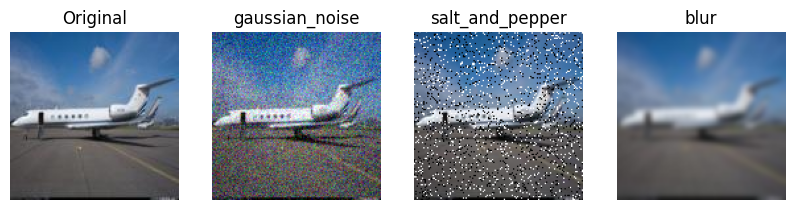

In [19]:
# Define noise functions

def add_gaussian_noise(image, mean=0, std=0.1):
    """Add Gaussian noise to the image."""
    np_image = np.array(image) / 255.0  # Normalize to [0, 1]
    noise = np.random.normal(mean, std, np_image.shape)
    noisy_image = np.clip(np_image + noise, 0, 1) * 255  # De-normalize to [0, 255]
    return Image.fromarray(noisy_image.astype(np.uint8))

def add_salt_and_pepper_noise(image, amount=0.05):
    """Add salt-and-pepper noise to the image."""
    np_image = np.array(image)
    total_pixels = np_image.size
    num_salt = int(amount * total_pixels / 2)
    num_pepper = int(amount * total_pixels / 2)

    coords_salt = [
        np.random.randint(0, i, num_salt) for i in np_image.shape[:2]
    ]
    coords_pepper = [
        np.random.randint(0, i, num_pepper) for i in np_image.shape[:2]
    ]

    np_image[coords_salt[0], coords_salt[1]] = 255
    np_image[coords_pepper[0], coords_pepper[1]] = 0
    return Image.fromarray(np_image.astype(np.uint8))

def blur_image(image, radius=2):
    """Apply Gaussian blur to the image."""
    return image.filter(ImageFilter.GaussianBlur(radius))

class ApplyNoiseTransform:
    """A callable transform that applies a given noise function."""
    def __init__(self, noise_function):
        self.noise_function = noise_function

    def __call__(self, img):
        return self.noise_function(img)

def noise_transform(noise_function):
    """Return a transform that applies the given noise function."""
    return transforms.Compose([
        transforms.Resize((550, 550)),
        transforms.CenterCrop(448),
        ApplyNoiseTransform(noise_function),  # Use custom callable class
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

def save_noisy_images(image_path, output_folder):
    """Generate noisy versions of the image and save them."""
    # Define noise functions
    noise_functions = {
        "gaussian_noise": add_gaussian_noise,
        "salt_and_pepper": add_salt_and_pepper_noise,
        "blur": blur_image
    }

    # Load the original image
    image = Image.open(image_path).convert("RGB")
    image_name = os.path.basename(image_path)

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Save the original image
    original_path = os.path.join(output_folder, f"original_{image_name}")
    image.save(original_path)
    print(f"Original image saved at {original_path}")

    # Display the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, len(noise_functions) + 1, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    # Apply each noise function and save the noisy images
    for idx, (noise_name, noise_function) in enumerate(noise_functions.items(), start=2):
        noisy_image = noise_function(image)
        noisy_image_path = os.path.join(output_folder, f"{noise_name}_{image_name}")
        noisy_image.save(noisy_image_path)
        print(f"Noisy image ({noise_name}) saved at {noisy_image_path}")

        # Display the noisy image
        plt.subplot(1, len(noise_functions) + 1, idx)
        plt.imshow(noisy_image)
        plt.title(noise_name)
        plt.axis('off')

# Show all images
plt.tight_layout()
plt.show()


image_path = "downsampled_plane_data/test/Gulfstream/1950559.jpg"
output_folder = "noised_images"
save_noisy_images(image_path, output_folder)

In [ ]:
import csv
def test_with_noise(net, criterion, batch_size, test_path, noise_function, noise_name):
    net.eval()

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    transform_test = noise_transform(noise_function)

    testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

    test_loss = 0
    correct = 0
    total = 0
    csv_rows = []

    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = Variable(inputs), Variable(targets)

        with torch.no_grad():
            output = net(inputs)
            output = output[0]

        loss = criterion(output, targets).mean()

        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)

        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # Save details for each batch
        for idx in range(inputs.size(0)):
            image_name = testset.samples[batch_idx * batch_size + idx][0]
            csv_rows.append({
                "Image Name": image_name,
                "Ground Truth": int(targets[idx].cpu().item()),
                "Prediction": int(predicted[idx].cpu().item())
            })

        if batch_idx % 50 == 0:
            log_message = (f'Step: {batch_idx} | Loss: {test_loss / (batch_idx + 1):.3f} | '
                           f'Combined Acc: {100. * float(correct) / total:.3f}% ({correct}/{total})')
            print(log_message)

    test_acc_en = 100. * float(correct) / total
    test_loss = test_loss / (batch_idx + 1)

    final_message = f'Final Accuracy: {test_acc_en:.2f}% | Final Loss: {test_loss:.4f}'
    print(final_message)

    # Save the CSV file for this noise test
    csv_file = f"results_{noise_name}.csv"
    with open(csv_file, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["Image Name", "Ground Truth", "Prediction"])
        writer.writeheader()
        writer.writerows(csv_rows)
    print(f"Results saved to {csv_file}")

    net.train()

    return test_acc_en, test_loss

def test_with_all_noises(net, criterion, batch_size, test_path):
    """Test the model with all defined noise functions."""
    noise_functions = {
        "Gaussian Noise": add_gaussian_noise,
        "Salt and Pepper Noise": add_salt_and_pepper_noise,
        "Blur": blur_image
    }

    results = {}

    for noise_name, noise_function in noise_functions.items():
        print(f"\nTesting with {noise_name}...")
        res = test_with_noise(net, criterion, batch_size, test_path, noise_function, noise_name)
        acc, loss = res[0], res[1]
        results[noise_name] = {"Accuracy": acc, "Loss": loss}

    print("\nSummary of results:")
    for noise_name, metrics in results.items():
        print(f"{noise_name}: Accuracy = {metrics['Accuracy']:.2f}%, Loss = {metrics['Loss']:.4f}")

    return results

In [ ]:
def inference(batch_size=7, model_path='', num_class=196, data_path=''):
    # use_cuda = torch.cuda.is_available()
    use_cuda = torch.cuda.is_available()
    print(use_cuda)

    net_student = torch.load(model_path)
    if use_cuda:
      device = torch.device("cuda")
      net_student.to(device)
    results = test_with_all_noises(net_student, CELoss, batch_size, data_path + '/train')

# model_path = exp_dir+'/model.pth' # uncomment if you want to use the model you have just trained
model_path = "pretrained_models/fgvr_planes_teacher_model.pth"
data_path = "downsampled_StanfordCars_data"
inference(batch_size=7,
            model_path=model_path,
            num_class=196,
            data_path = data_path)

True


<ipython-input-32-799ee6081e26>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_student = torch.load(model_path)



Testing with Gaussian Noise...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step: 0 | Loss: 0.433 | Combined Acc: 100.000% (7/7)
Step: 50 | Loss: 0.436 | Combined Acc: 91.877% (328/357)
Final Accuracy: 91.97% | Final Loss: 0.4379
Results saved to results_Gaussian Noise.csv

Testing with Salt and Pepper Noise...
Step: 0 | Loss: 1.889 | Combined Acc: 14.286% (1/7)
Step: 50 | Loss: 1.625 | Combined Acc: 35.854% (128/357)
Final Accuracy: 35.28% | Final Loss: 1.6249
Results saved to results_Salt and Pepper Noise.csv

Testing with Blur...
Step: 0 | Loss: 0.047 | Combined Acc: 100.000% (7/7)
Step: 50 | Loss: 0.044 | Combined Acc: 100.000% (357/357)
Final Accuracy: 100.00% | Final Loss: 0.0452
Results saved to results_Blur.csv

Summary of results:
Gaussian Noise: Accuracy = 91.97%, Loss = 0.4379
Salt and Pepper Noise: Accuracy = 35.28%, Loss = 1.6249
Blur: Accuracy = 100.00%, Loss = 0.0452
